In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import re
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv


In [8]:
df_train = pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv", engine = 'python')
df_test = pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv", engine = 'python')

In [9]:
df = df_test.append(df_train)

In [10]:
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know its getting tough when @KameronWilds...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [11]:
sentiment = {"Extremely Negative":0, "Negative":1, "Neutral":2, "Positive":3, "Extremely Positive":4}

In [12]:
df.Sentiment = df.Sentiment.map(sentiment)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Sentiment', ylabel='count'>

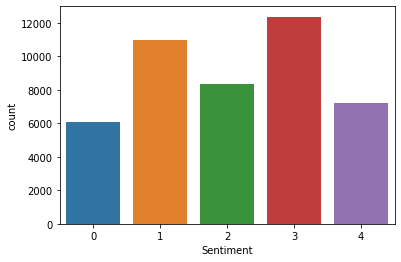

In [13]:
sns.countplot(df.Sentiment)

In [14]:
# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")


In [15]:

def preprocessing(text):
    re_text = "@\S+|http+\S+|\s[^A-Za-z0-9]\S+"
    text = re.sub(re_text, ' ', text).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(stemmer.stem(token))
            
    return ' '.join(tokens)

In [16]:
%%time
df.OriginalTweet = df.OriginalTweet.apply(lambda x: preprocessing(x))

CPU times: user 13.2 s, sys: 12.4 ms, total: 13.2 s
Wall time: 13.2 s


In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df.OriginalTweet, df.Sentiment, test_size = 0.1)

# **W2V**

In [19]:
import gensim


# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10


In [20]:
documents = [txt.split(' ') for txt in X_train]

In [21]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [22]:
w2v_model.build_vocab(documents)

In [23]:
words = w2v_model.wv.key_to_index
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 5550


In [24]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 1min 13s, sys: 424 ms, total: 1min 13s
Wall time: 39.2 s


(17834661, 22233376)

In [25]:
%%time
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 31289
CPU times: user 2.68 s, sys: 418 ms, total: 3.1 s
Wall time: 5.71 s


In [26]:
%%time
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=300)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=300)

CPU times: user 1.34 s, sys: 20 ms, total: 1.36 s
Wall time: 1.36 s


In [27]:
y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)

In [28]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(31289, 300)


In [29]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [30]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=300, trainable=False)

In [31]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          9386700   
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 9,547,201
Trainable params: 160,501
Non-trainable params: 9,386,700
_________________________________________________________________


In [32]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [33]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [34]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=20,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/20
72/72 [==============================] - 87s 1s/step - loss: -6.5971 - accuracy: 0.2371 - val_loss: -21.7538 - val_accuracy: 0.2457
Epoch 2/20
72/72 [==============================] - 82s 1s/step - loss: -24.3174 - accuracy: 0.2408 - val_loss: -30.8355 - val_accuracy: 0.2457
Epoch 3/20
72/72 [==============================] - 83s 1s/step - loss: -33.2617 - accuracy: 0.2400 - val_loss: -39.2932 - val_accuracy: 0.2457
Epoch 4/20
72/72 [==============================] - 82s 1s/step - loss: -41.3625 - accuracy: 0.2453 - val_loss: -47.5550 - val_accuracy: 0.2457
Epoch 5/20
72/72 [==============================] - 82s 1s/step - loss: -49.6429 - accuracy: 0.2414 - val_loss: -55.7480 - val_accuracy: 0.2457
Epoch 6/20
72/72 [==============================] - 82s 1s/step - loss: -57.3097 - accuracy: 0.2458 - val_loss: -63.8574 - val_accuracy: 0.2457
Epoch 7/20
72/72 [==============================] - 82s 1s/step - loss: -65.7778 - accuracy: 0.2453 - val_loss: -71.9228 - val_accuracy: 

In [35]:
%%time
score = model.evaluate(X_test, y_test, batch_size=300)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

15/15 [==============================] - 1s 85ms/step - loss: -175.5811 - accuracy: 0.2484

ACCURACY: 0.24844306707382202
LOSS: -175.5810546875
CPU times: user 1.32 s, sys: 12.9 ms, total: 1.33 s
Wall time: 1.32 s


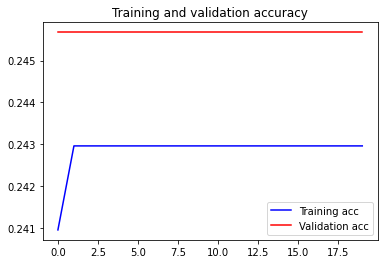

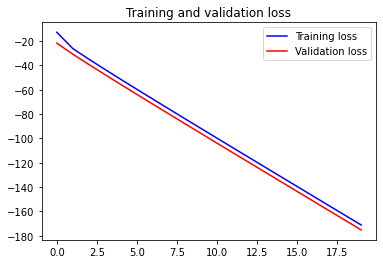

In [37]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [38]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = "NEUTRAL"
        if score <= 0.4:
            label = "NEGATIVE"
        elif score >= 0.7:
            label = "POSITIVE"

        return label
    else:
        return "NEGATIVE" if score < 0.5 else "POSITIVE"

In [45]:
import time
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=300)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [46]:

predict("i don't know what i'm doing")

{'label': 'POSITIVE', 'score': 1.0, 'elapsed_time': 0.2977256774902344}

In [47]:
%%time
y_pred_1d = []
y_test_1d = list(y_test)
scores = model.predict(X_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

1/1 [==============================] - 1s 505ms/step
CPU times: user 516 ms, sys: 63.8 ms, total: 580 ms
Wall time: 544 ms
